# Figures for the hospitalization model

In [1]:
library(here)
source(here("setup.R"))


here() starts at /Users/stefan/workspace/work/phd/thesis



## Application 1: Showcase

In [2]:
np <- import("numpy")
predictions <- np$load("/Users/stefan/workspace/work/phd/thesis/data/results/4_hospitalizations/showcase/predictions_age_00-04.npy")
dim(predictions)
dates <- seq(from = ymd("2021-11-22"), to = ymd("2022-04-28"), by = "1 day")
length(dates)

n_delay <- 5
variables <- c(
    "prob_hosp",
    paste0("p_delay_smooth", seq(n_delay)),
    paste0("p_delay", seq(n_delay)),
    "weekday_0",
    "weekday_1",
    "avg_delay"
)
length(variables)

Warning message in poetry_config(required_module):
“This project appears to use Poetry for Python dependency management.
However, the 'poetry' command line tool is not available.
reticulate will be unable to activate this project.
Please ensure that 'poetry' is available on the PATH.”


[1]  25 158  14

[1] 158

[1] 14

In [3]:
df_files <- tibble(fname = list.files(here("data/results/4_hospitalizations/showcase"), full.names = T)) %>%
    filter(str_detect(fname, ".npy$")) %>%
    # mutate(age_group = paste0("A", str_extract(fname, "\\d\\d-\\d\\d"))) %>%
    mutate(age_group = c("A00-04", "A00+", "A05-14", "A15-34", "A35-59", "A60-79", "A80+")) %>%
    mutate(n_delay = c(5, 8, 5, 7, 7, 8, 8))

read_age_predictions <- function(fname, n_delay) {
    dates <- seq(from = ymd("2021-11-22"), to = ymd("2022-04-28"), by = "1 day")
    variables <- c(
        "prob_hosp",
        paste0("p_delay_smooth", seq(n_delay)),
        paste0("p_delay", seq(n_delay)),
        "weekday_0",
        "weekday_1",
        "avg_delay"
    )

    print(fname)
    read_predictions(fname, dates, variables)
}

df_predictions <- df_files %>%
    mutate(data = map2(fname, n_delay, read_age_predictions)) %>%
    select(-fname, -n_delay) %>%
    unnest() %>%
    mutate(age_group = ordered_age_group(age_group))


[1] "/Users/stefan/workspace/work/phd/thesis/data/results/4_hospitalizations/showcase/predictions_age_00-04.npy"
[1] "/Users/stefan/workspace/work/phd/thesis/data/results/4_hospitalizations/showcase/predictions_age_00+.npy"
[1] "/Users/stefan/workspace/work/phd/thesis/data/results/4_hospitalizations/showcase/predictions_age_05-14.npy"
[1] "/Users/stefan/workspace/work/phd/thesis/data/results/4_hospitalizations/showcase/predictions_age_15-34.npy"
[1] "/Users/stefan/workspace/work/phd/thesis/data/results/4_hospitalizations/showcase/predictions_age_35-59.npy"
[1] "/Users/stefan/workspace/work/phd/thesis/data/results/4_hospitalizations/showcase/predictions_age_60-79.npy"
[1] "/Users/stefan/workspace/work/phd/thesis/data/results/4_hospitalizations/showcase/predictions_age_80+.npy"


Warning message:
“`cols` is now required when using `unnest()`.
ℹ Please use `cols = c(data)`.”


## Same-day nowcasts

In [4]:
df_predictions %>%
    distinct(variable) %>%
    pull()


[1] prob_hosp       p_delay_smooth1 p_delay_smooth2 p_delay_smooth3
 [5] p_delay_smooth4 p_delay_smooth5 p_delay1        p_delay2       
 [9] p_delay3        p_delay4        p_delay5        weekday_0      
[13] weekday_1       avg_delay       p_delay_smooth6 p_delay_smooth7
[17] p_delay_smooth8 p_delay6        p_delay7        p_delay8       
20 Levels: prob_hosp p_delay_smooth1 p_delay_smooth2 ... p_delay8

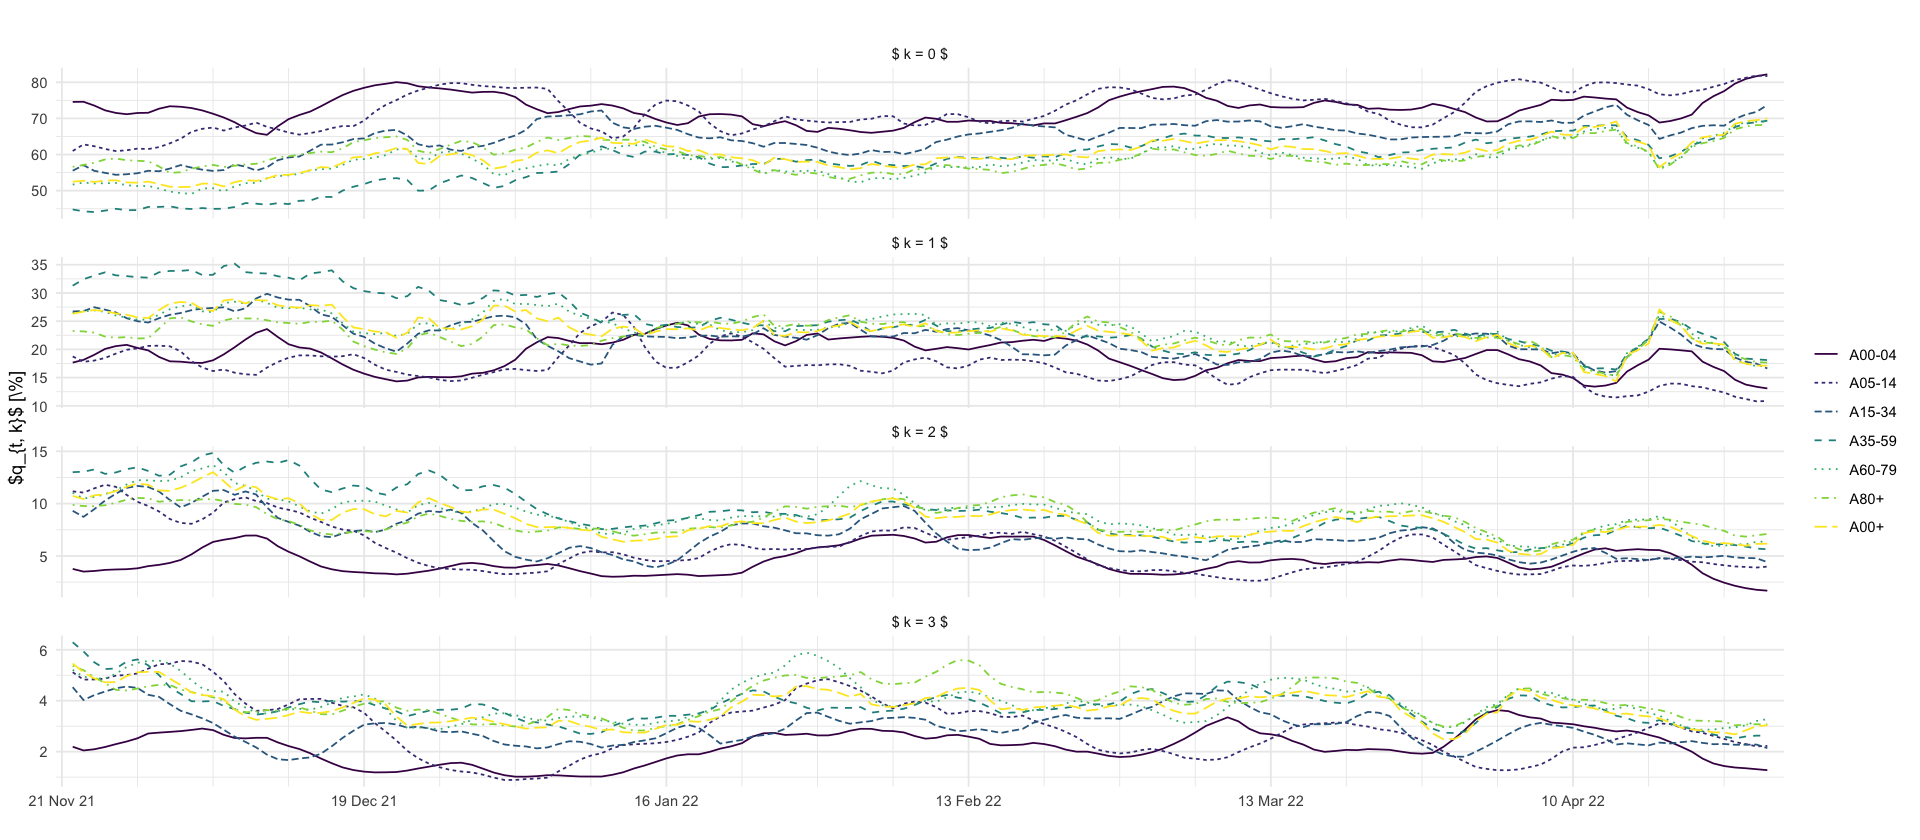

In [5]:
p_smoothed_delays <- df_predictions %>%
    select(age_group, date, variable, mean, `0.025`, `0.5`, `0.975`) %>%
    filter(str_detect(variable, "p_delay_smooth")) %>%
    mutate(variable = str_replace(variable, "p_delay_smooth", "")) %>%
    rename(k = variable) %>%
    mutate(k = as.numeric(k) - 1) %>%
    filter(k <= 3) %>%
    ggplot(aes(x = date, y = mean * 100, color = age_group, group = age_group, linetype = age_group)) +
    geom_line() +
    # geom_ribbon(aes(ymin = `0.025` * 100, ymax = `0.975` * 100, fill = age_group), alpha = 0.2) +
    labs(
        title = "",
        x = "",
        y = "$q_{t, k}$ [\\%]",
        color = "",
        linetype = ""
    ) +
    scale_x_four_weekly() +
    facet_wrap(~k, scales = "free_y", nrow = 4, labeller = labeller(k = function(x) str_glue("$ k = {x} $")))
p_smoothed_delays


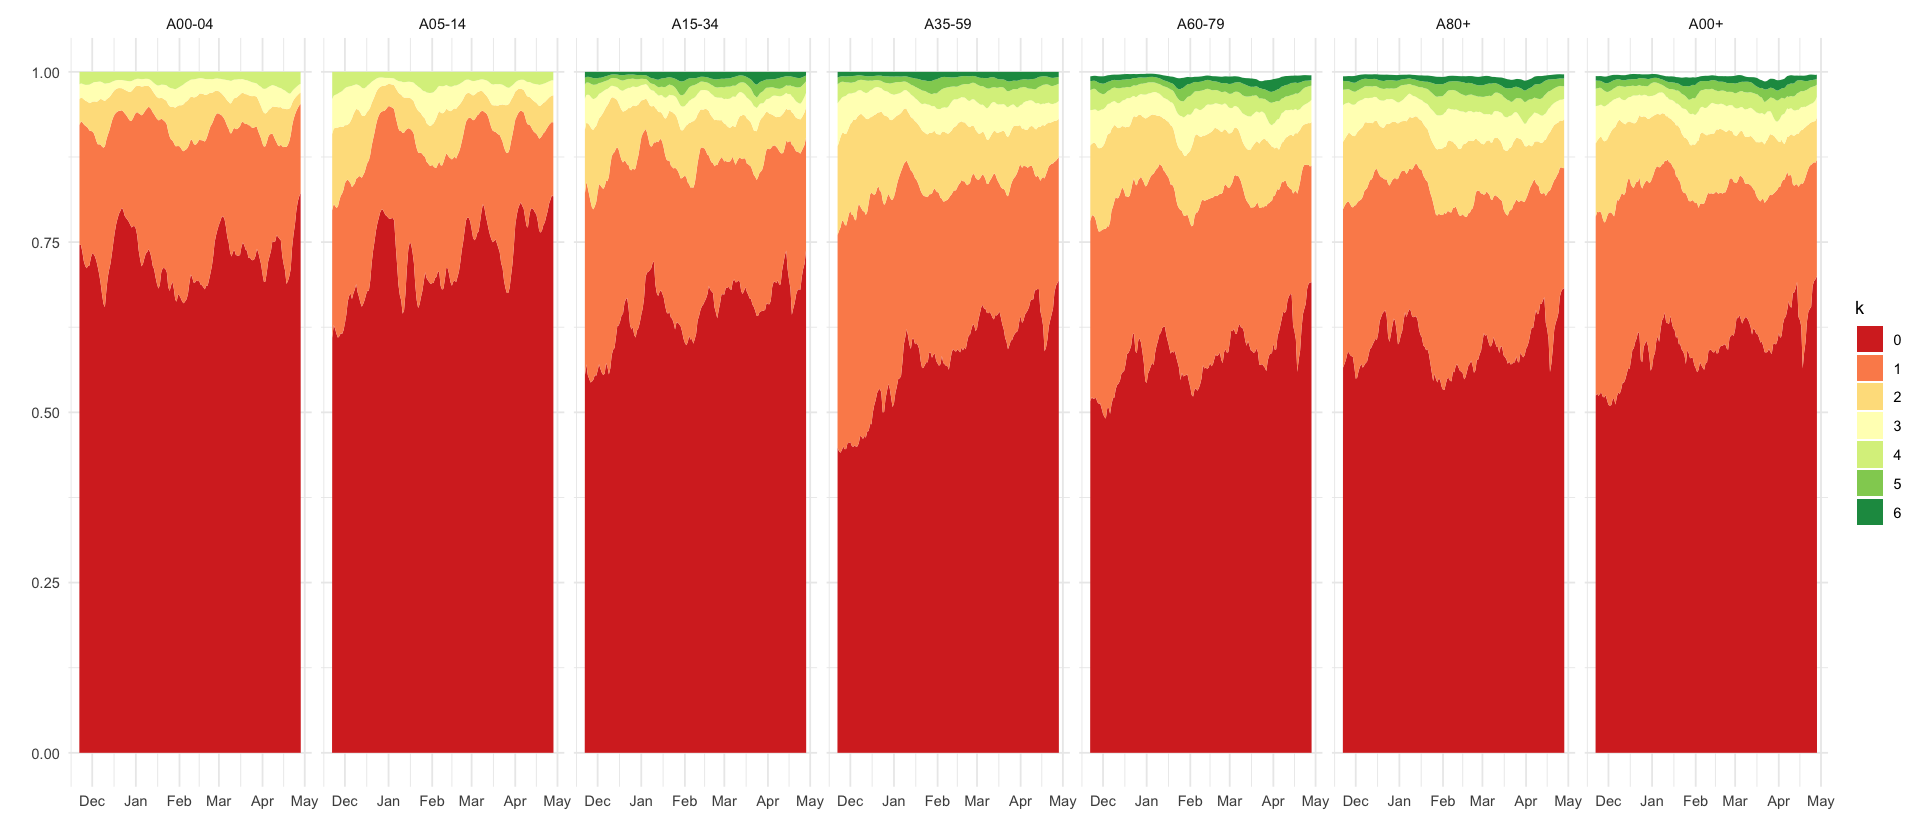

In [6]:
df_predictions %>%
    select(age_group, date, variable, mean, `0.025`, `0.5`, `0.975`) %>%
    filter(str_detect(variable, "p_delay_smooth")) %>%
    mutate(variable = str_replace(variable, "p_delay_smooth", "")) %>%
    rename(k = variable) %>%
    mutate(k = as.numeric(k) - 1) %>%
    filter(k <= 6) %>%
    mutate(k = factor(k)) %>%
    select(age_group, date, k, mean) %>%
    complete(age_group, date, k, fill = list(mean = 0)) %>%
    ggplot(aes(date, mean, fill = k)) +
    geom_area(position = position_stack(reverse = T)) +
    facet_wrap(~age_group, nrow = 1) +
    scale_fill_brewer(palette = "RdYlGn") +
    labs(x = "", y = "")


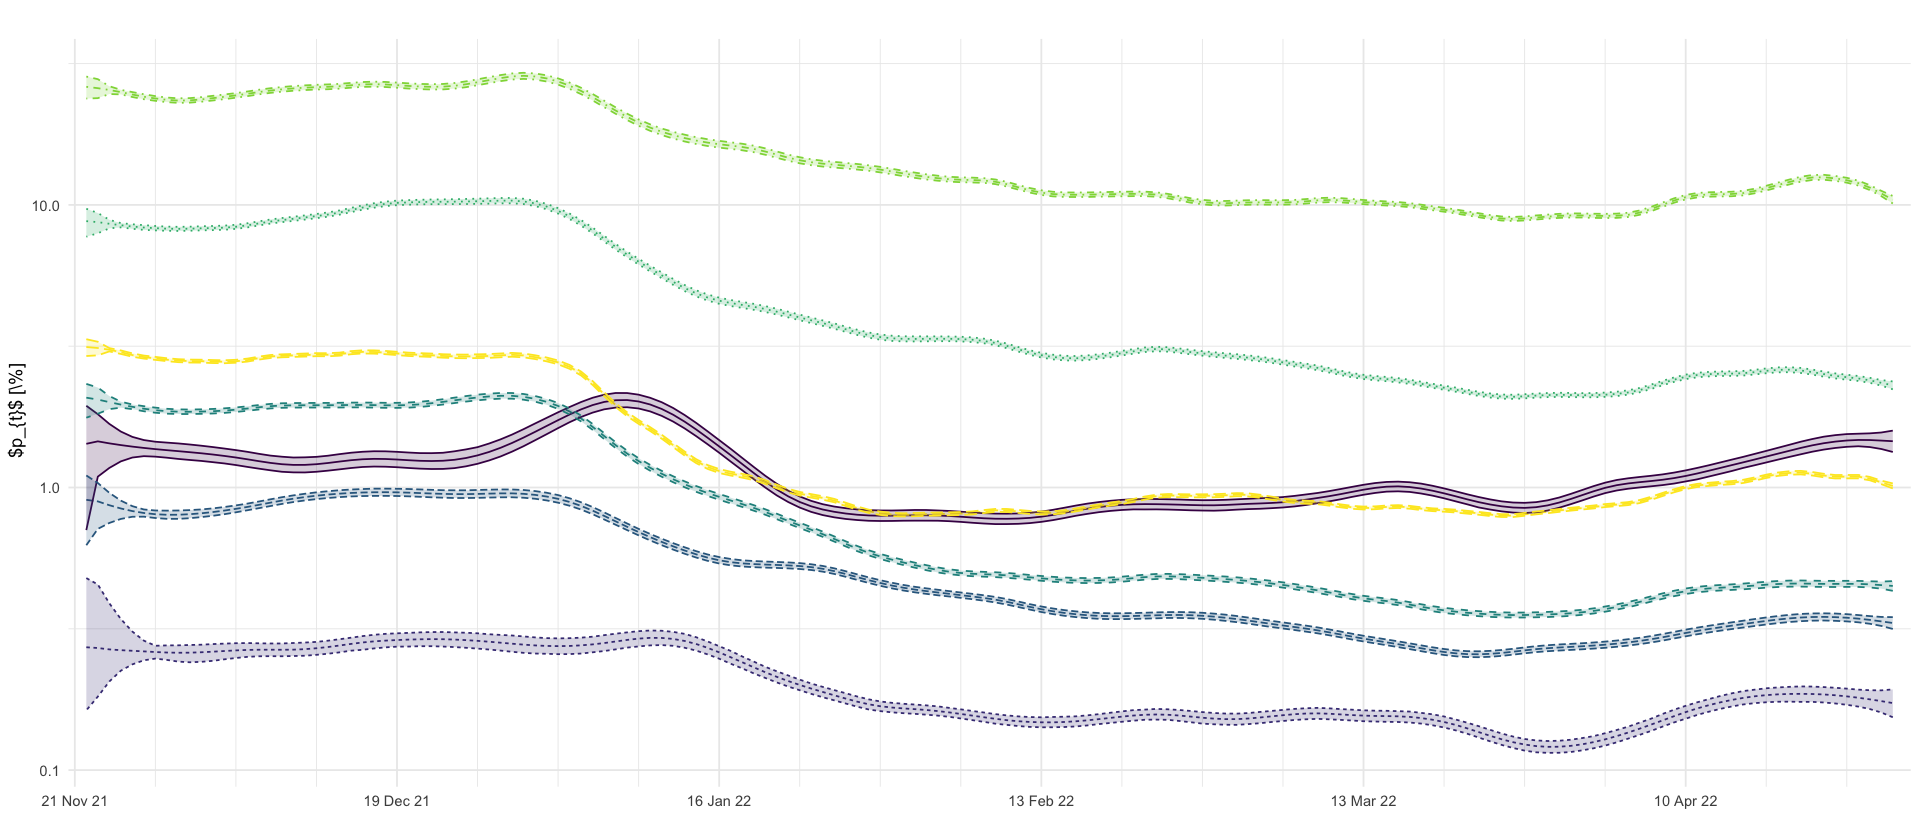

In [7]:
p_hospitalizations <- df_predictions %>%
    select(age_group, date, variable, mean, `0.025`, `0.5`, `0.975`) %>%
    filter(variable == "prob_hosp") %>%
    ggplot(aes(x = date, y = mean * 100, color = age_group, group = age_group, linetype = age_group)) +
    geom_line() +
    geom_ribbon(aes(ymin = `0.025` * 100, ymax = `0.975` * 100, fill = age_group), alpha = 0.2) +
    labs(
        title = "",
        x = "",
        y = " $p_{t}$ [\\%]"
    ) +
    scale_x_four_weekly() +
    scale_y_log10() +
    theme(legend.position = "none")
p_hospitalizations


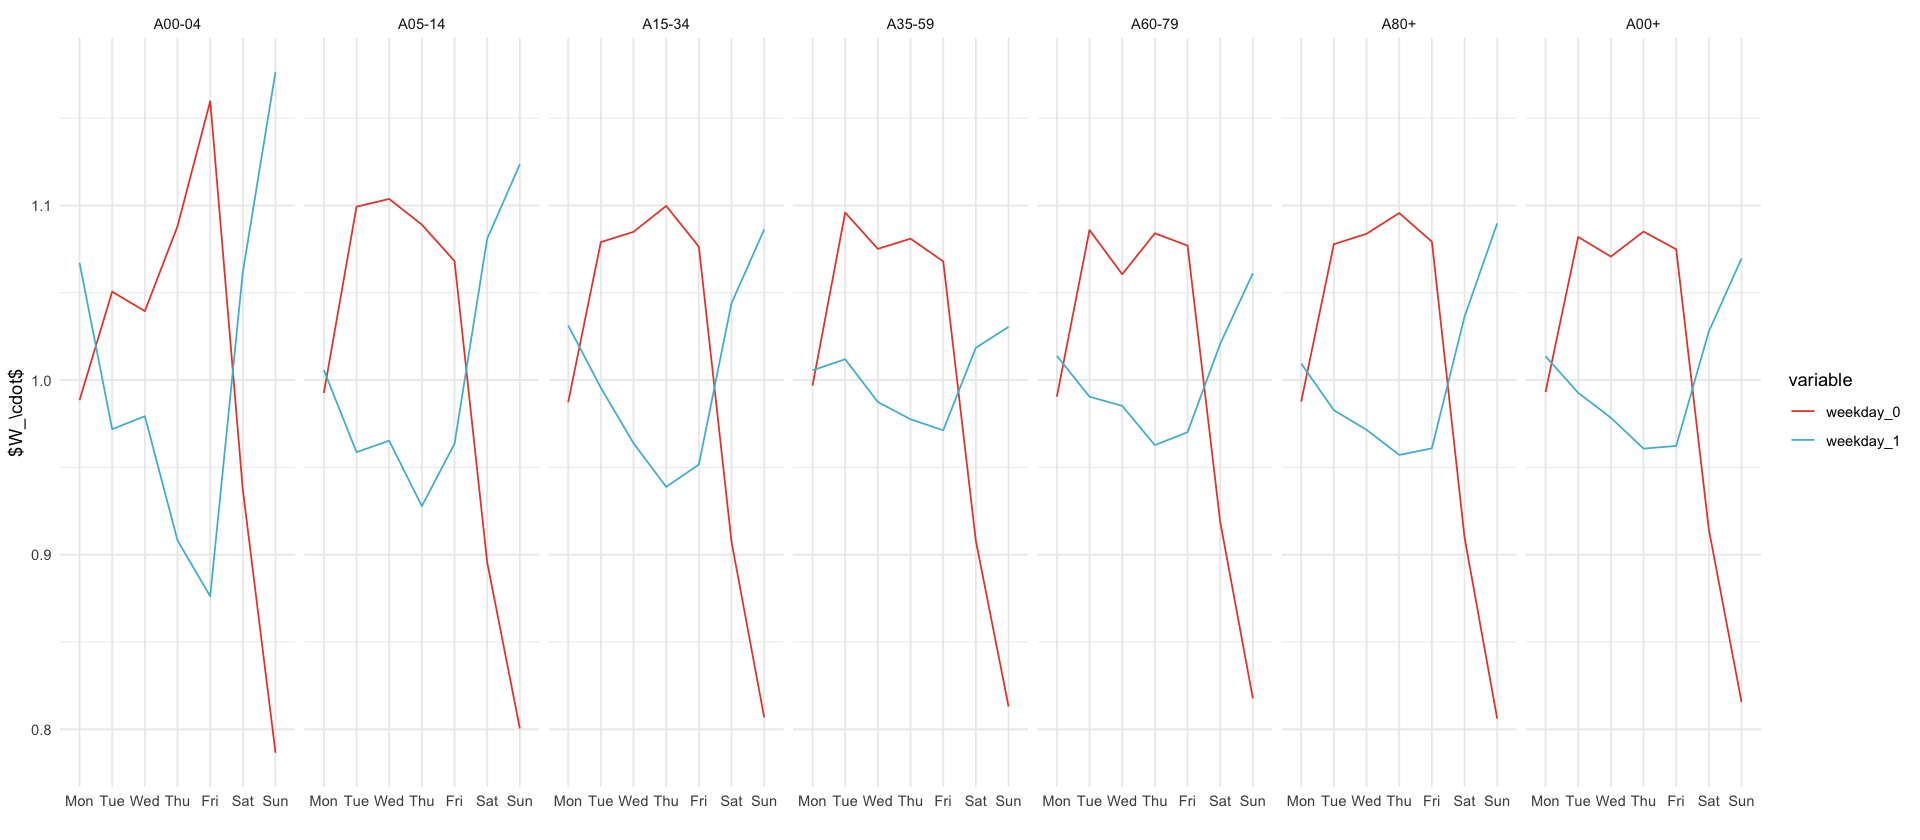

In [8]:
df_predictions %>%
    select(age_group, date, variable, mean, `0.025`, `0.5`, `0.975`) %>%
    filter(str_detect(variable, "weekday")) %>%
    ggplot(aes(x = wday(date, label = T, week_start = 1), mean, color = variable, group = variable)) +
    stat_summary(fun = mean, geom = "line") +
    facet_wrap(~age_group, nrow = 1) +
    xlab("") +
    ylab("$W_\\cdot$")


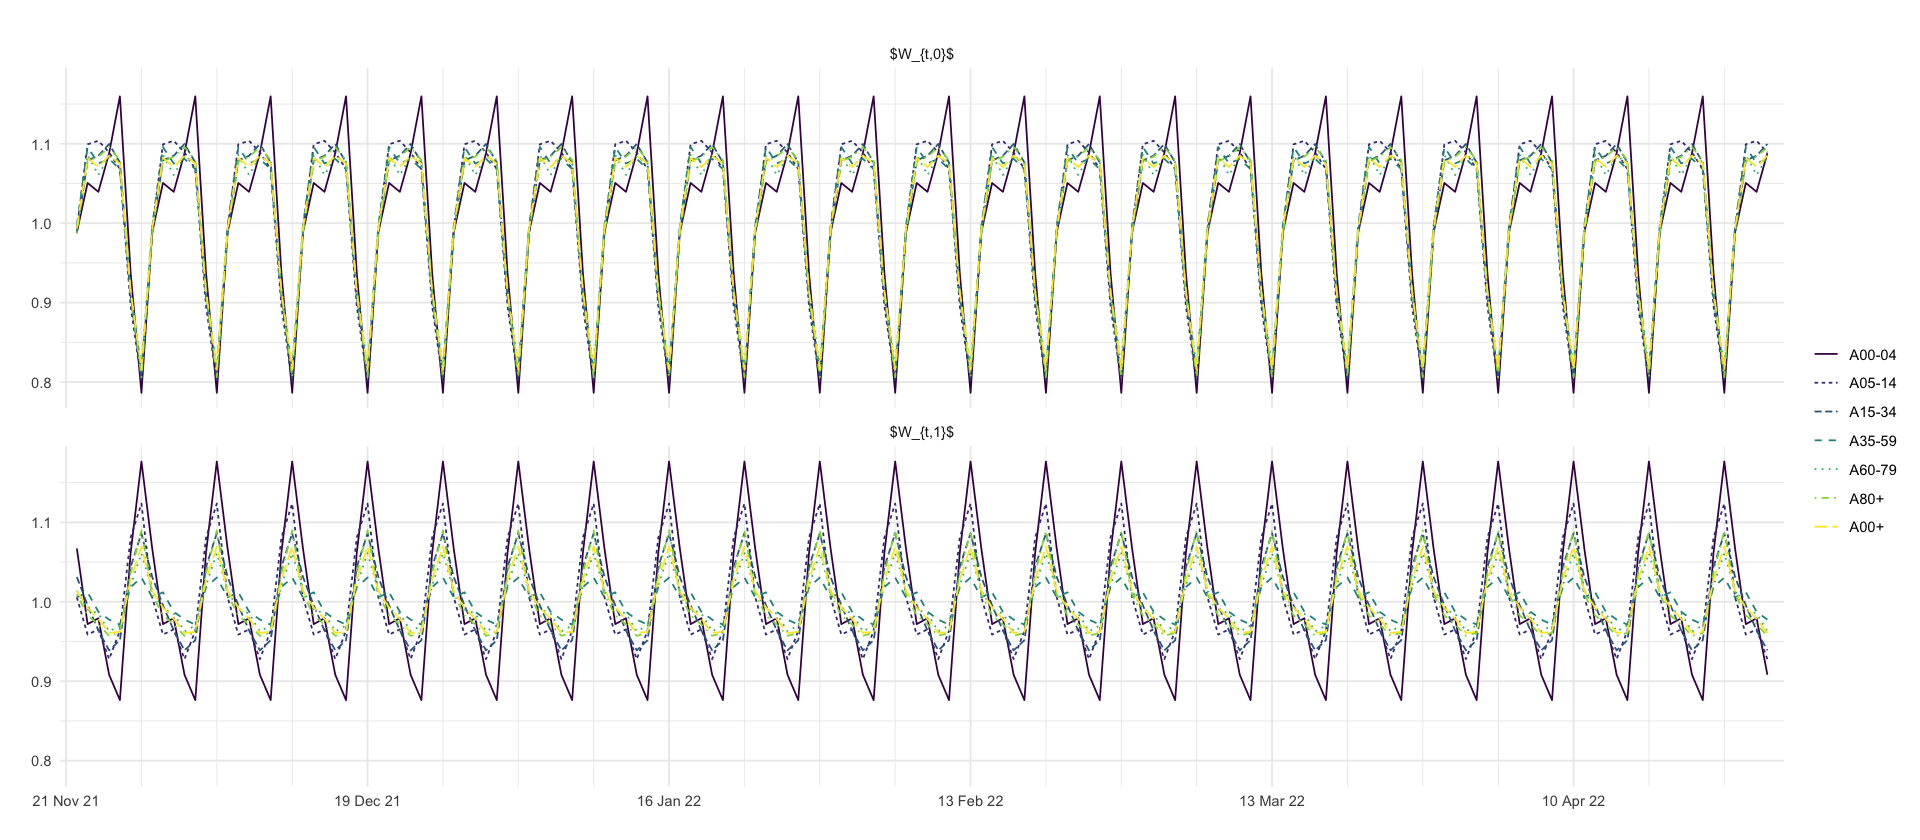

In [9]:
p_weekday <- df_predictions %>%
    select(age_group, date, variable, mean, `0.025`, `0.5`, `0.975`) %>%
    filter(str_detect(variable, "weekday")) %>%
    ggplot(aes(x = date, y = mean, color = age_group, group = age_group, linetype = age_group)) +
    geom_line() +
    # geom_ribbon(aes(ymin = `0.025` * 100, ymax = `0.975` * 100, fill = age_group), alpha = 0.2) +
    labs(
        title = "",
        x = "",
        y = "",
        linetype = "",
        color = ""
    ) +
    scale_x_four_weekly() +
    facet_wrap(~variable, nrow = 2, labeller = as_labeller(c("weekday_0" = "$W_{t,0}$", "weekday_1" = "$W_{t,1}$")))
p_weekday


pdf 
  2

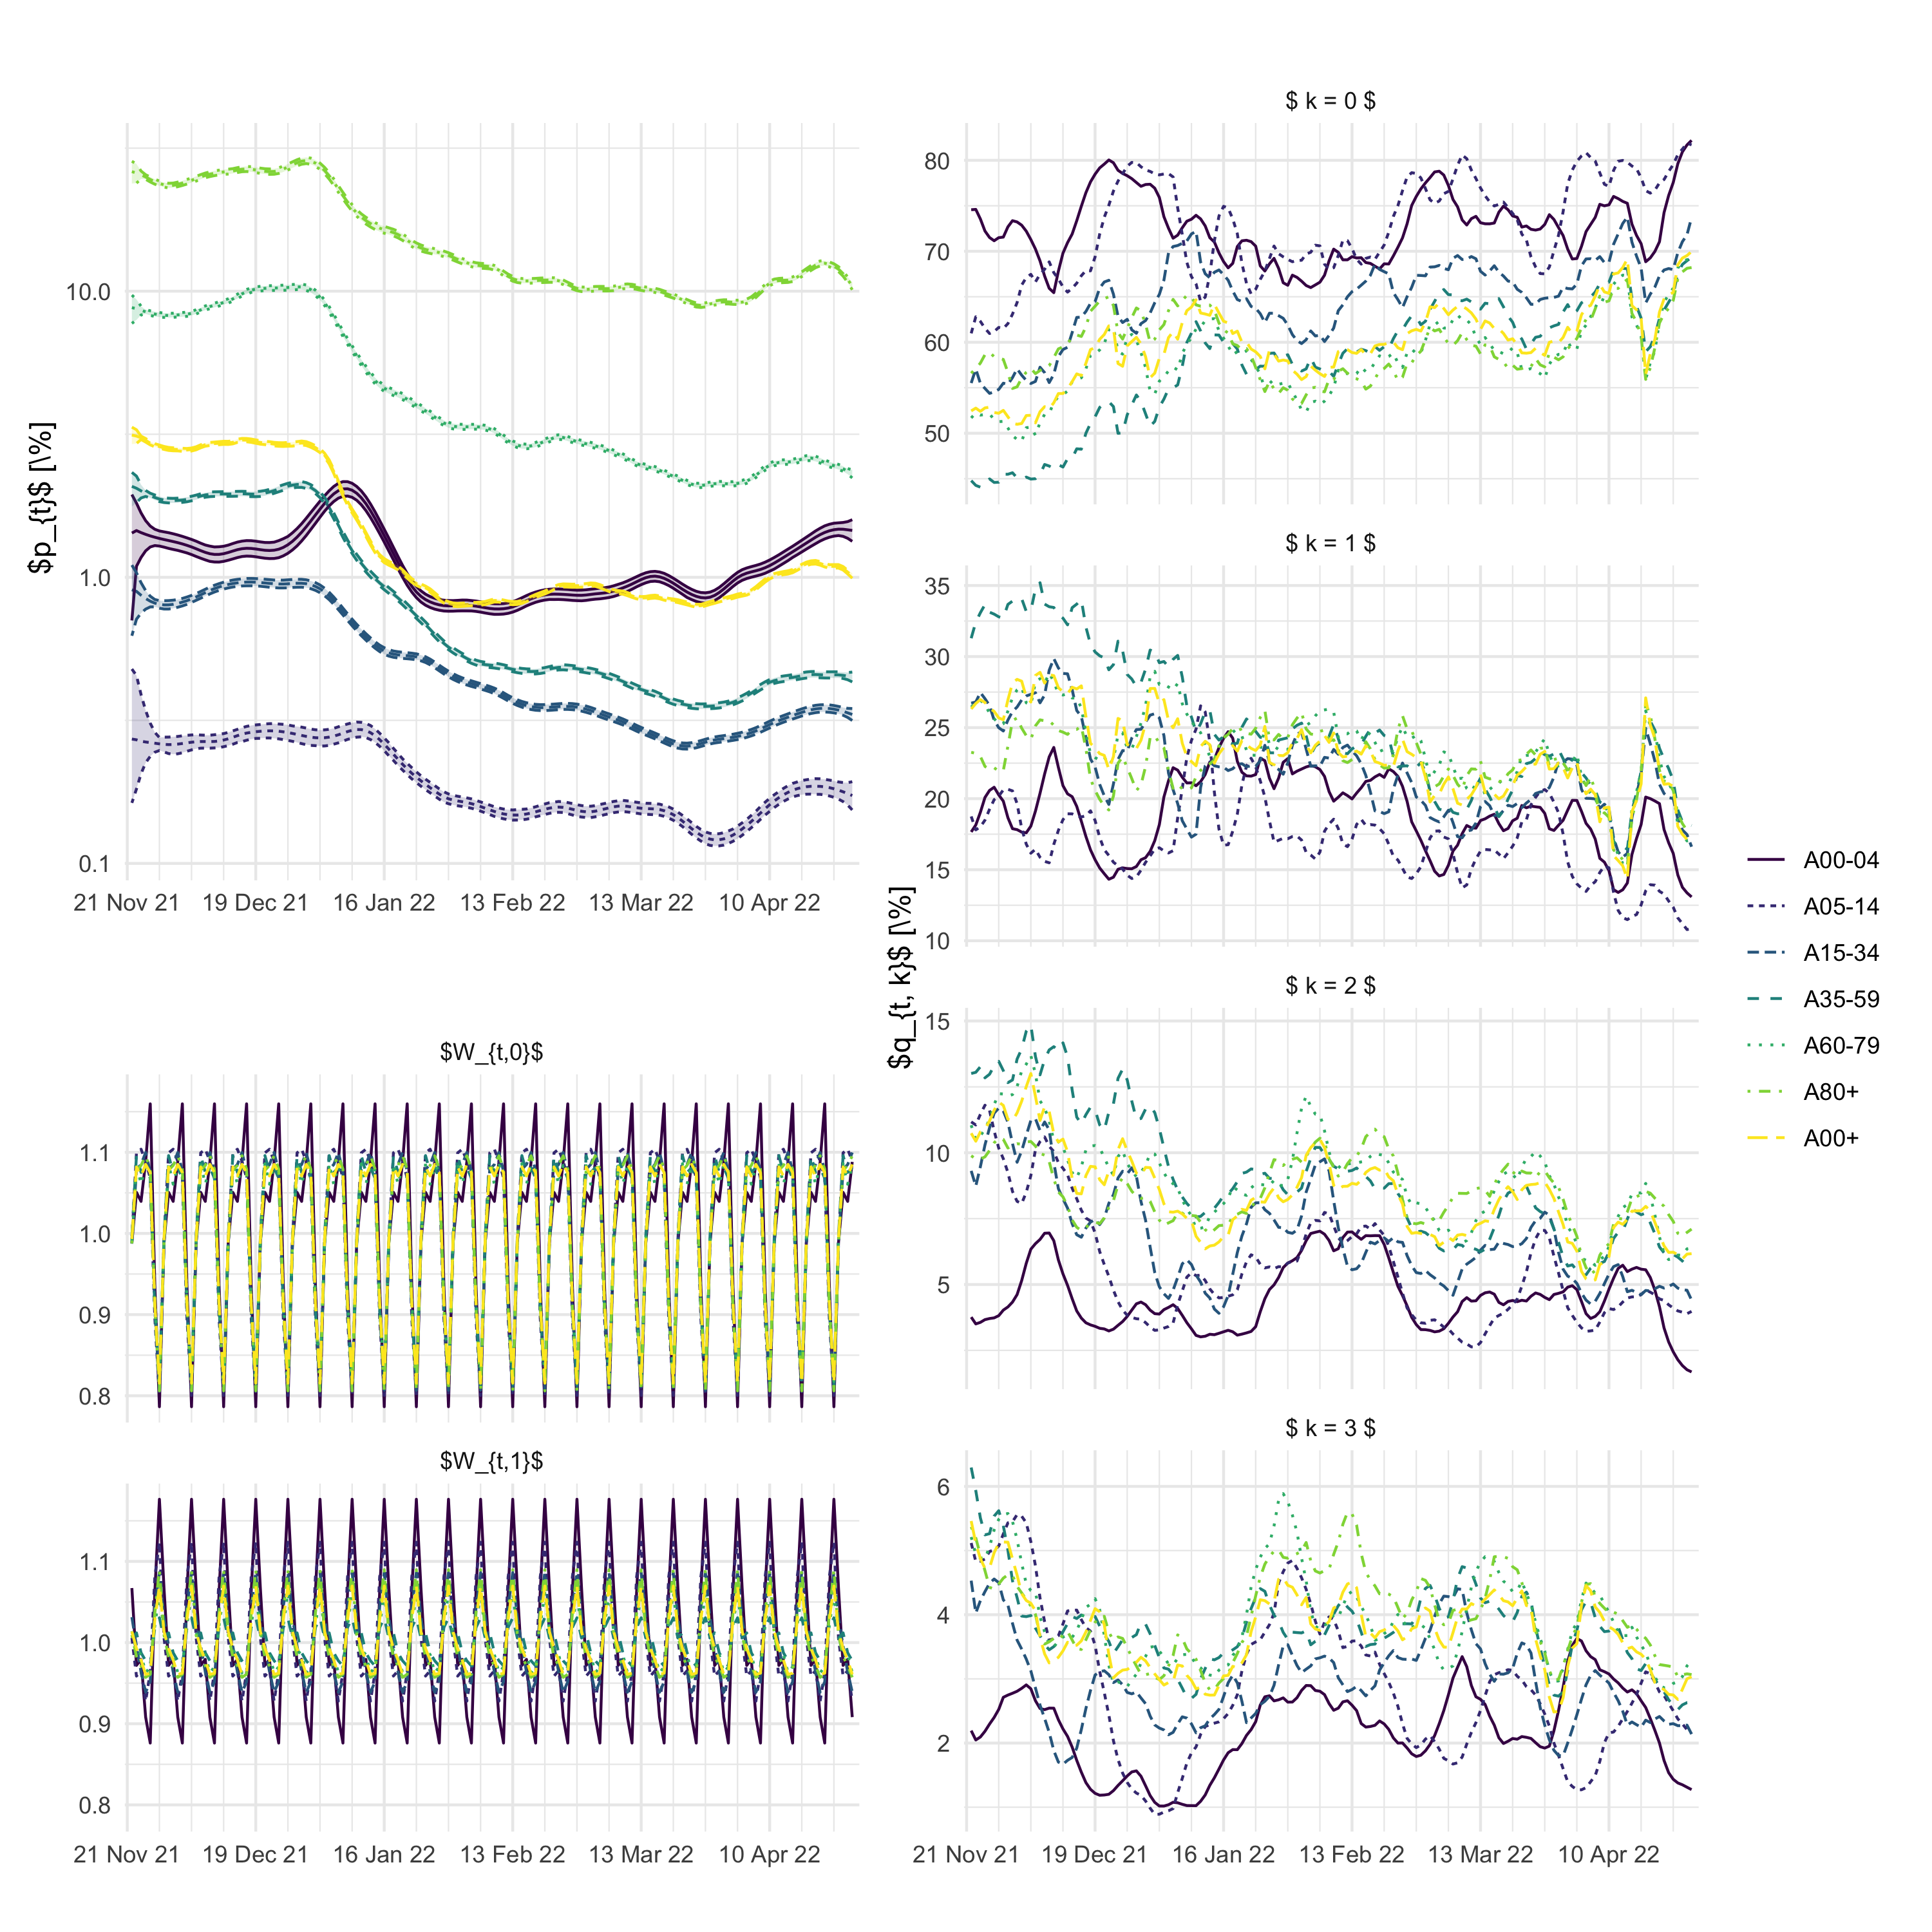

In [10]:
h <- 10
w <- 10
options(
    repr.plot.width = w,
    repr.plot.height = h,
    repr.plot.res = 300
)
((p_hospitalizations / p_weekday) | p_smoothed_delays) + plot_layout(guides = "collect")
# (p_hospitalizations / p_smoothed_delays / p_weekday) + plot_layout(guides = "collect")


ggsave_tikz(here("tikz/hospitalization_showcase_results.tex"), width = w, height = h)


## Same-day nowcasts

In [11]:
library(here)
source(here("setup.R"))

In [ ]:
df_nowcast <- read_csv(here("data/results/4_hospitalizations/nowcast/nowcast.csv")) %>%
    mutate(across(mean:`97.5 %`, ~ ifelse(. > 1e5, NA, .))) 
start_date <- min(df_nowcast$date)
end_date <- max(df_nowcast$date)

df_nowcast

mean      sd           2.5 %    10.0 % 25.0 %    50.0 %   75.0 %  
1    9924.819 2.177689e+02 9400.000  9646   9783.000  9962    10133   
2   10380.229 4.520120e+02 9449.000 10002  10236.000 10357    10377   
3    9938.246 5.659940e+02 9622.000  9622   9622.000  9741     9741   
4   10287.936 6.639332e+02 9421.000  9611   9664.186 10134    10688   
5    9941.979 7.899787e+02 8891.373  8953   9307.000  9836    10455   
6   10120.425 8.017649e+02 9049.000  9169   9524.000 10043    10720   
7   10596.912 9.475039e+02 9342.000  9522   9882.000 10308    11305   
8   10272.902 6.711387e+02 9169.000  9682   9830.000 10109    10468   
9    9621.779 6.915240e+02 8415.000  8565   9323.000  9619     9967   
10         NA           NA       NA    NA         NA    NA       NA   
11   9406.518 4.599873e+02 8612.000  8958   9253.000  9354     9402   
12         NA           NA       NA    NA         NA    NA       NA   
13  10303.294 6.200344e+02 8795.000  9634  10374.000 10418    10418   
14   9528.940 6.574359e+02 8839.000  8839   9016.000  9328     9948   
15  10112.864 4.650720e+02 9660.000  9846   9846.000  9899    10316   
16         NA           NA       NA    NA         NA    NA       NA   
17   5592.000 2.441406e-04 5592.000  5592   5592.000  5592     5592   
18  10282.374 6.059454e+02 9294.000  9492   9916.000 10134    10739   
19   9216.515 2.823873e+02 9080.000  9080   9080.000  9137     9137   
20  10347.933 8.211236e+02 9277.000  9711   9780.000  9916    11003   
21  10594.465 3.479891e+02 9859.000 10206  10435.000 10584    10734   
22   9786.591 1.616370e+02 9407.000  9555   9744.000  9788     9846   
23   9531.292 8.198393e+02 8520.000  8520   8756.000  9361    10298   
24   9234.345 4.208159e+02 8539.000  8680   8854.000  9256     9438   
25   9034.932 3.875434e+01 8976.000  8995   9027.000  9033     9033   
26   9264.193 7.348912e+02 7757.000  8195   8855.000  9236     9692   
27   8899.183 5.968157e+02 7653.000  7946   8576.000  9190     9301   
28   8691.419 5.043713e+02 8042.000  8221   8559.000  8559     8691   
29   8733.692 4.264295e+02 7655.000  8143   8524.650  8917     9090   
30   8341.061 2.796265e+02 7469.000  8038   8425.000  8425     8425   
⋮   ⋮         ⋮            ⋮        ⋮      ⋮         ⋮        ⋮       
72   7236.839 371.29429    6755.000 6755    6874.000  7269.00  7525.00
73   7798.232 290.65430    7307.000 7355    7474.000  7891.00  7978.00
74   8450.250 318.53597    7852.000 8126    8276.000  8346.00  8728.00
75         NA        NA          NA   NA          NA       NA       NA
76   4847.000   0.00000    4847.000 4847    4847.000  4847.00  4847.00
77         NA        NA          NA   NA          NA       NA       NA
78   9737.026 224.28839    9293.000 9623    9623.000  9693.00  9775.00
79   9705.172  47.14892    9629.000 9672    9682.000  9682.00  9717.00
80  10217.951 327.99143    9468.000 9601   10081.000 10343.00 10405.00
81   9964.096 426.96065    9368.265 9615    9714.000  9761.00 10206.00
82   9989.808 659.63539    9172.000 9352    9517.000  9796.00 10325.00
83   9970.278 210.93518    9532.000 9532    9893.000 10050.00 10050.00
84  10114.418 540.06256    8725.571 9548    9869.803 10089.00 10428.00
85  10445.358 550.94074    9324.816 9742   10267.000 10477.00 10594.00
86   9516.701 731.43735    8427.000 8548    8661.672  9707.00  9885.00
87   9783.781 396.63131    9095.000 9400    9639.000  9669.00  9864.00
88  10604.522 581.40255    9317.000 9966   10289.000 10769.00 10769.00
89   9760.796 576.56344    9175.000 9343    9515.000  9515.00  9990.00
90  10195.236 699.50826    9166.000 9427    9659.000 10112.00 10468.00
91  10583.353 610.18673    9233.000 9714   10119.000 10934.40 11083.00
92  10300.224 601.40048    9331.000 9569    9914.000 10293.00 10472.00
93   9655.262 620.28579    8680.000 8758    9181.690  9613.00 10117.00
94   9886.134 672.66856    8943.000 9191    9492.000  9694.00 10176.00
95  10263.804 687.14813    8974.000 9351    9792.000 10380.00 10791.69
96  10571.660 905.39022    8

In [13]:
add_all_age_groups_to_truth <- function(df) {
    all_ages <- df %>%
        group_by(case_date) %>%
        summarise(value = sum(value), .groups = "drop") %>%
        mutate(age_group = "00+") %>%
        select(age_group, case_date, value)

    rbind(df, all_ages) %>%
        arrange(case_date, age_group)
}


In [14]:
delay_6_weeks_truth <- read_csv(here("data/raw/all_hosp_age.csv")) %>%
    filter(hosp_date - case_date == 6 * 7) %>%
    filter(case_date >= start_date, case_date <= end_date) %>%
    select(age_group, case_date, value) %>%
    add_all_age_groups_to_truth() %>%
    filter(age_group == "00+")  %>%
    select(date = case_date, value)

In [15]:
df_ilm_prop42 <- read_csv(here("data/results/4_hospitalizations/nowcast/ilm_prop42.csv")) %>%
    mutate(date = ymd(date)) %>%
    filter(date >= start_date, date <= end_date)
    

df_nch_ensemble <- read_csv(here("data/results/4_hospitalizations/nowcast/nch_ensemble.csv")) %>%
    mutate(date = ymd(date)) %>%
    filter(date >= start_date, date <= end_date)


In [16]:
all_df <- rbind(
    df_ilm_prop42 %>%
        mutate(model = "ILM-prop42"),
    df_nch_ensemble %>%
        mutate(model = "NCH ensemble"),
    df_nowcast %>%
        mutate(model = "SSM")
)

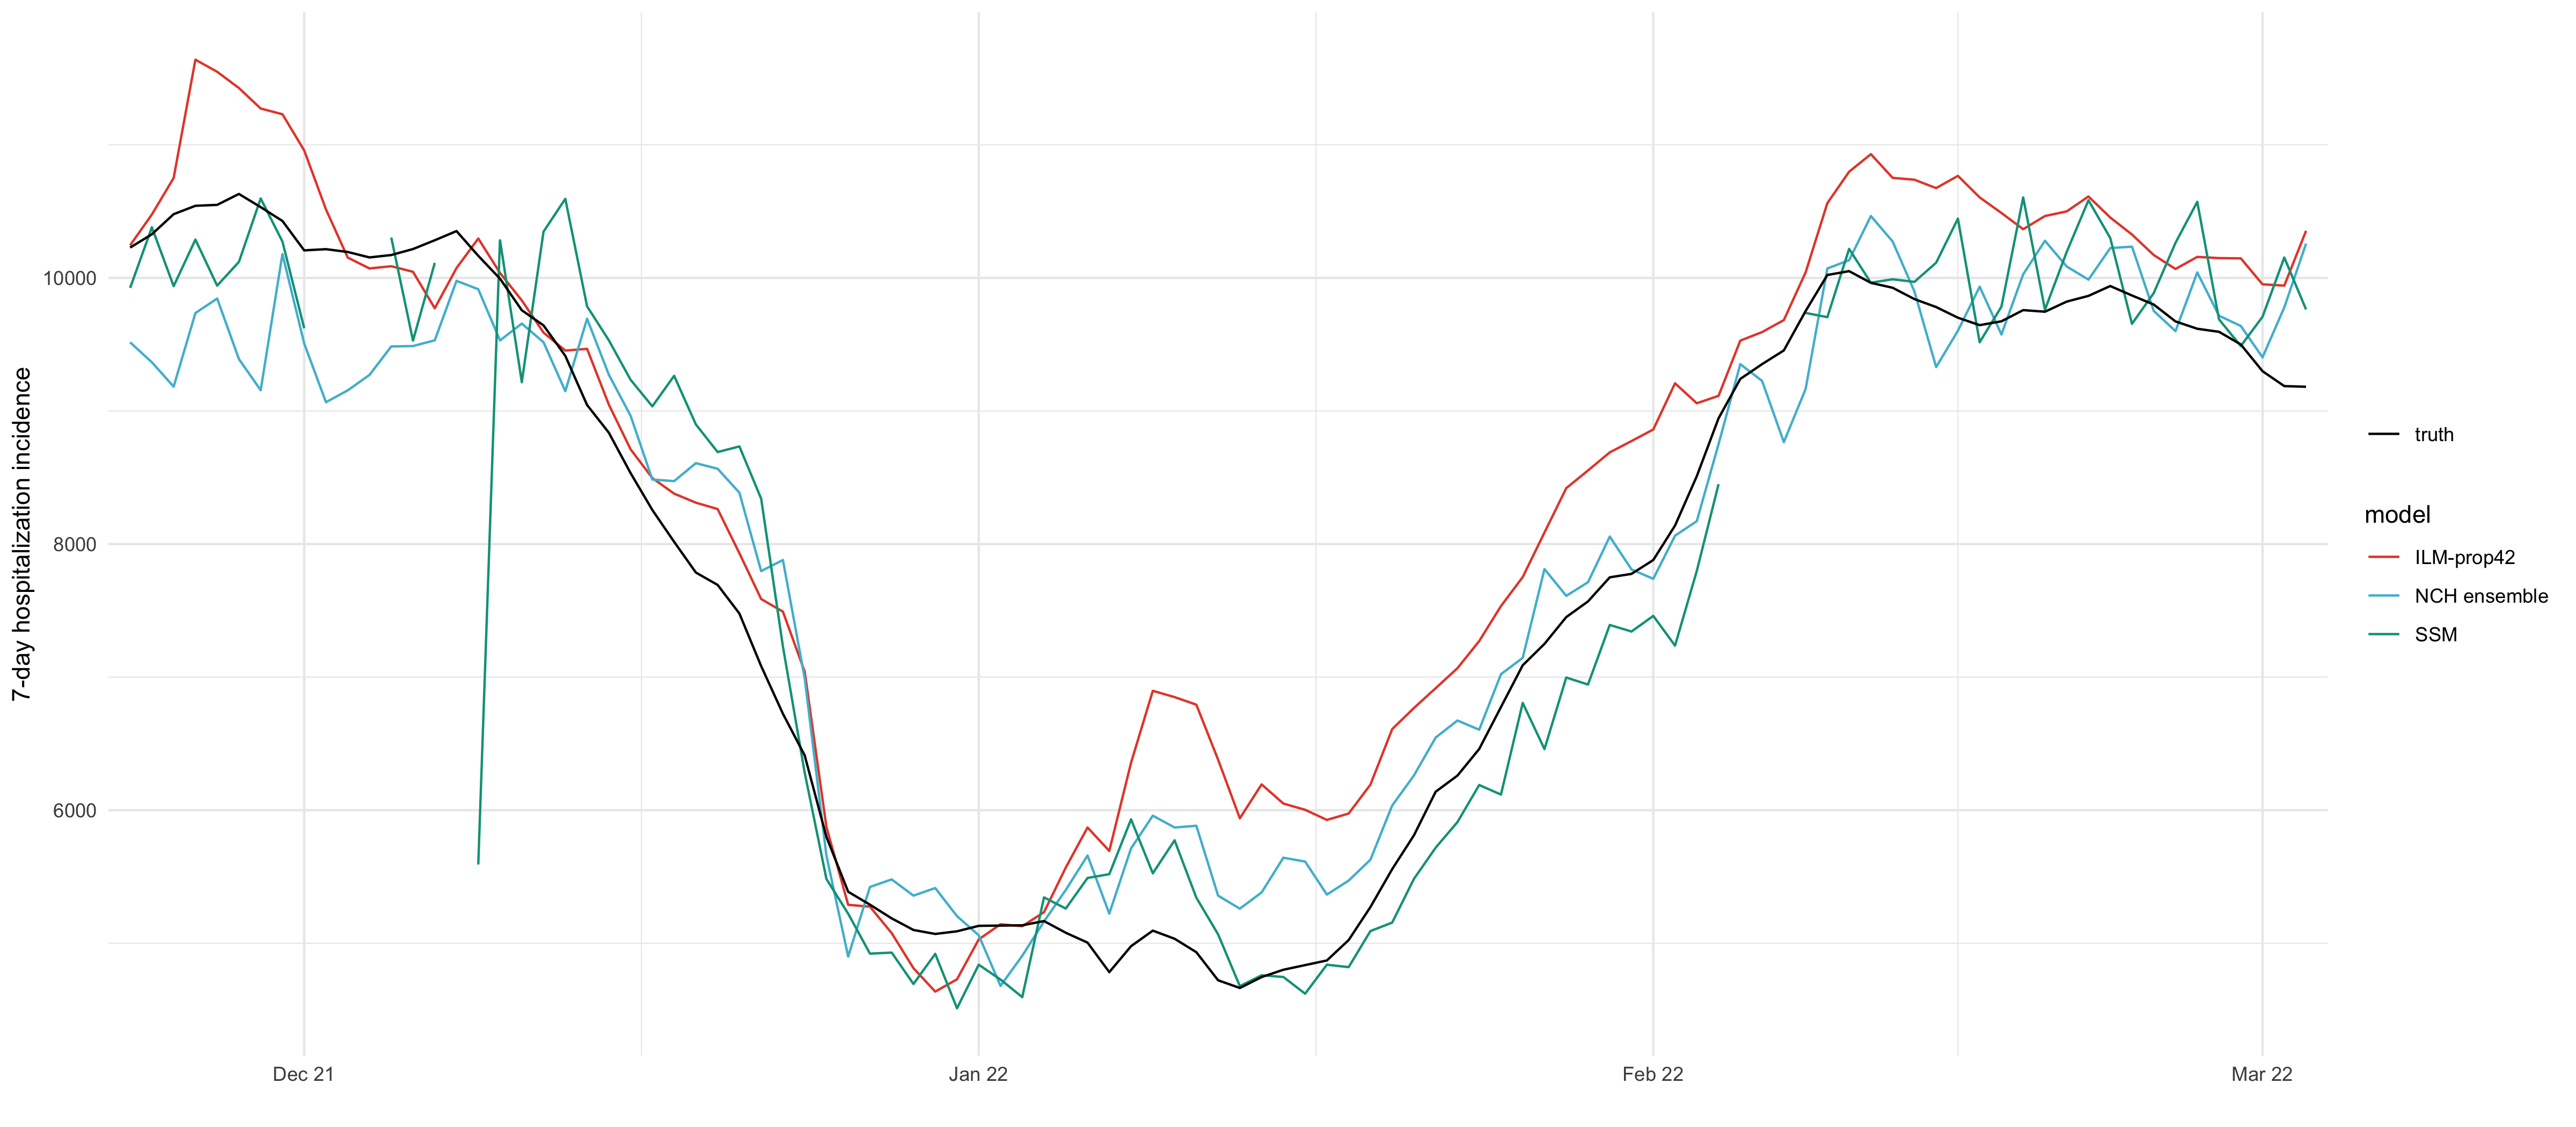

In [17]:
ggplot(all_df, aes(date)) +
    geom_line(aes(y=mean, color=model)) +
    geom_line(aes(x = date, y = value, linetype = "truth"), data = delay_6_weeks_truth) +
    labs(x = "", y = "7-day hospitalization incidence", linetype = NULL, fill = NULL) +
    scale_x_date(breaks = "1 months", date_labels = "%b %y", expand = expansion(mult = c(0.01, 0.01)))

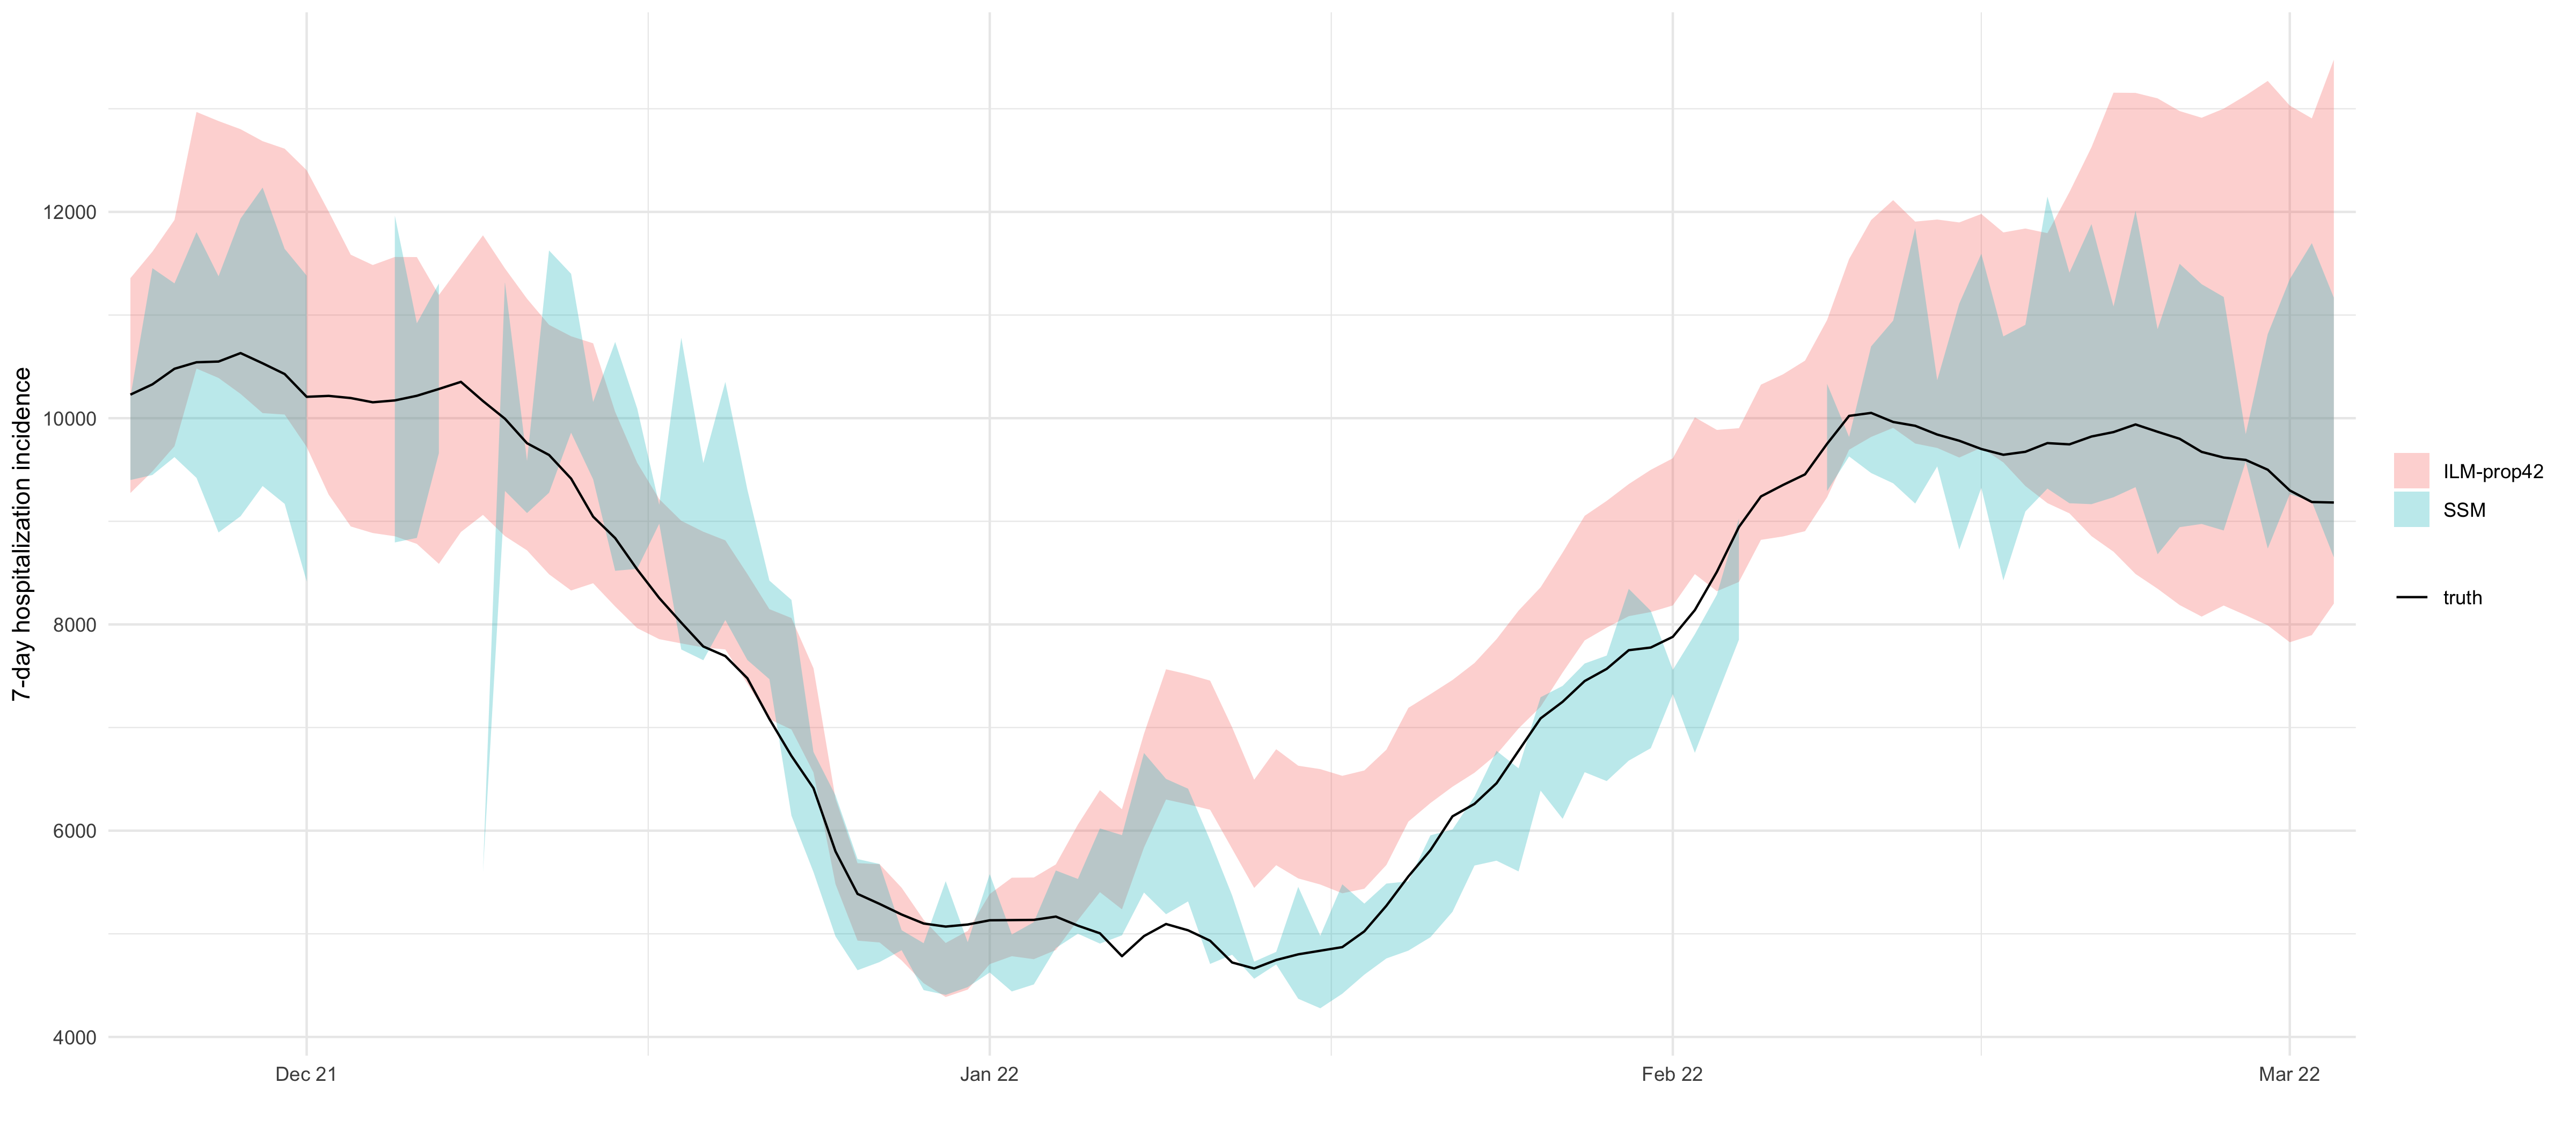

In [22]:
all_df %>%
    filter(model %in% c("SSM", "ILM-prop42")) %>%
    ggplot(aes(date)) +
    geom_ribbon(aes(ymin = `2.5 %`, ymax = `97.5 %`, fill = model), alpha = 0.3) +
    geom_line(aes(x = date, y = value, linetype = "truth"), data = delay_6_weeks_truth) +
    labs(x = "", y = "7-day hospitalization incidence", linetype = NULL, fill = NULL) +
    scale_x_date(breaks = "1 months", date_labels = "%b %y", expand = expansion(mult = c(0.01, 0.01)))

In [19]:
quantiles <- c(0.025, 0.100, 0.250, 0.500, 0.750, 0.900, 0.975)
# interval score
IS <- function(prob, lower, upper, y) {
    (upper - lower) + (y < lower) * 2 / prob * (lower - y) + (y > upper) * 2 / prob * (y - upper)
}
# weighted interval score
WIS <- function(prob, quant, actual) {
    K <- length(prob)

    # count median twice
    prob <- c(prob[seq((K + 1) / 2)], prob[seq((K + 1) / 2, K)])

    wk <- prob / 2
    lower_quant <- quant[seq((K + 1) / 2)]
    upper_quant <- quant[seq(K, (K + 1) / 2, by = -1)]

    1 / (K + 1) * sum(wk * IS(prob, lower_quant, upper_quant, actual))
}

In [21]:
delay_6_weeks_truth %>% 
    inner_join(all_df, by="date") %>%
    rename(truth=value) %>%
    group_by(model) %>%
    summarize(
        mae = mean(abs(mean - truth), na.rm = TRUE),
        coverage_95 = mean(`2.5 %` <= truth & truth <= `97.5 %`, na.rm = TRUE),
        coverage_50 = mean(`25.0 %` <= truth & truth <= `75.0 %`, na.rm = TRUE),
        WIS = mean(WIS(quantiles, c_across(`2.5 %`:`97.5 %`), truth))
    ) 

Warning message:
“There were 24 warnings in `summarize()`.
The first warning was:
ℹ In argument: `WIS = mean(WIS(quantiles, c_across(`2.5 %`:`97.5 %`), truth))`.
ℹ In group 1: `model = "ILM-prop42"`.
Caused by warning in `y < lower`:
! Länge des längeren Objektes
 	 ist kein Vielfaches der Länge des kürzeren Objektes
ℹ Run `dplyr::last_dplyr_warnings()` to see the 23 remaining warnings.”


model        mae      coverage_95 coverage_50 WIS     
1 ILM-prop42   629.7129 0.6534653   0.3960396   25582.86
2 NCH ensemble 458.3168 0.8712871   0.4356436   23692.92
3 SSM          529.6143 0.6979167   0.2812500   24849.12